## Load Data

In [2]:
import pandas as pd
import numpy as np
import time
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.FilterCatalog import *

raw_df = pd.read_csv('../datasets/data.csv')
raw_df.columns = ['Original SMILES', 'Hit']
raw_df['Hit'] = raw_df['Hit'].apply(lambda x: 1 if x == 'Yes' else 0).astype(float)

In [6]:
raw_df['Hit'].sum(), raw_df['Hit'].shape[0] - 7

(7.0, 155)

---
## Generate Features and Train Models

In [55]:
FP_radius=4
FP_size=2056
saltRemover = SaltRemover(defnFilename='../datasets/Salts.txt')
rdkit_train_mols = raw_df['Original SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
rdkit_train_mols = rdkit_train_mols.apply((lambda x: saltRemover.StripMol(x)))
raw_df['rdkit SMILES'] = rdkit_train_mols.apply((lambda x: Chem.MolToSmiles(x)))
raw_df['MorganFP_{}_{}'.format(FP_radius, FP_size)] = rdkit_train_mols.apply((lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 
                                                                                       radius=FP_radius, 
                                                                                       nBits=FP_size).ToBitString()))

In [56]:
X_train = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in raw_df['MorganFP_{}_{}'.format(FP_radius, FP_size)]]).astype(float) 
y_train = raw_df['Hit'].values

# RandomForest Model
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=8000, 
                                  max_features='log2', 
                                  min_samples_leaf=1, 
                                  n_jobs=4, 
                                  class_weight='balanced',
                                  random_state=20190613,
                                  verbose=0)
rf_model.fit(X_train, y_train)
rf_train_preds = rf_model.predict_proba(X_train)[:,1]

# Similarity Baseline model
from baseline_similarity import SimilarityBaseline
bl_model = SimilarityBaseline()
bl_model.fit(X_train, y_train)
bl_train_preds, closest_active_idx = bl_model.predict_proba(X_train)
closest_active_idx = closest_active_idx[:,0]
bl_train_preds = bl_train_preds[:,0]

C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


---
## Training Set Depictions

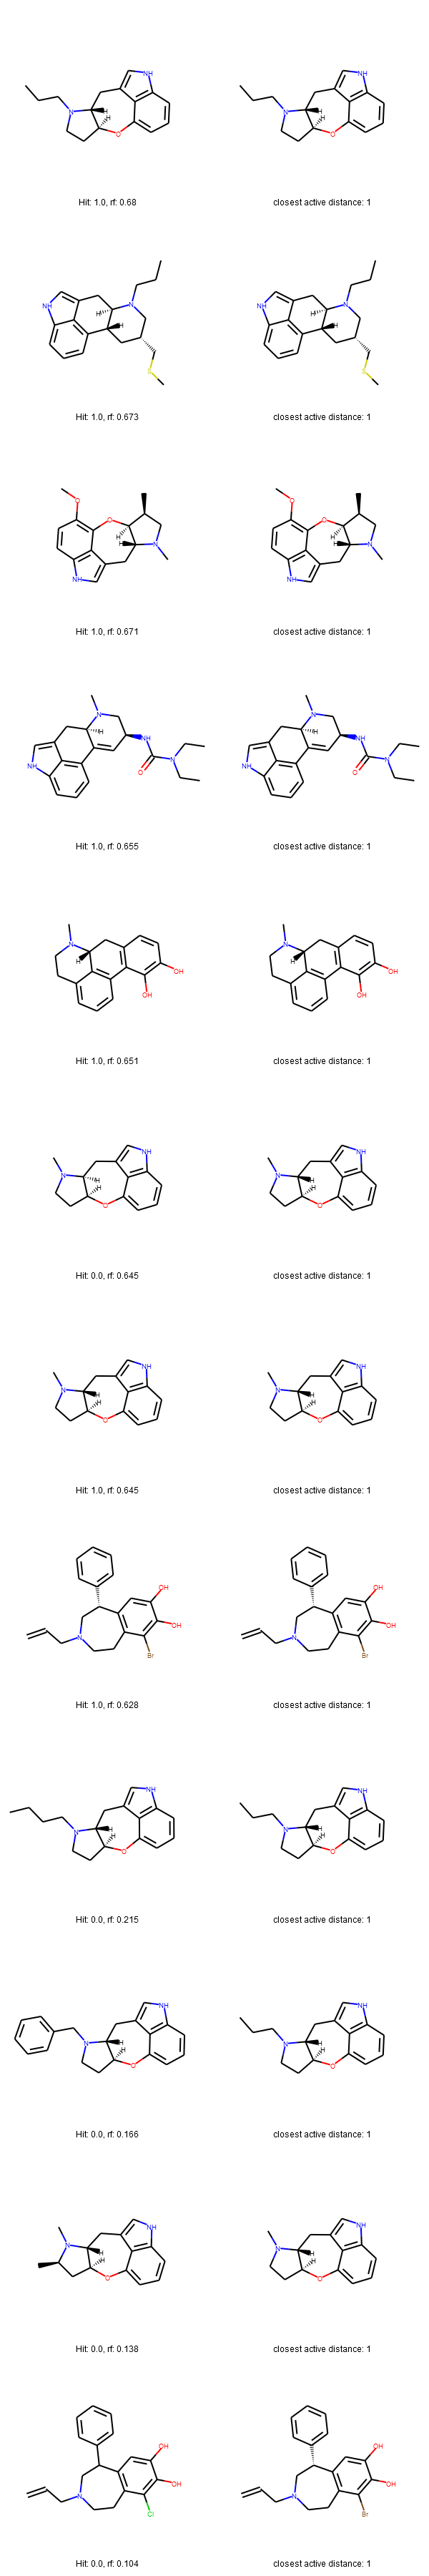

In [57]:
from rdkit.Chem import Draw
for m in rdkit_train_mols: tmp=AllChem.Compute2DCoords(m)
active_idx = np.where(y_train == 1)[0]
topk = 12
draw_mols = []
[draw_mols.extend([rdkit_train_mols.iloc[i], rdkit_train_mols.iloc[closest_active_idx[i]]]) for i in np.argsort(rf_train_preds)[::-1][:topk]]

legends = []
[legends.extend(['Hit: {}, rf: {:.3g}'.format(y_train[i], rf_train_preds[i]), 
                 'closest active distance: {:.3g}'.format(bl_train_preds[closest_active_idx[i]])]) for i in np.argsort(rf_train_preds)[::-1][:topk]]

img=Draw.MolsToGridImage(draw_mols,molsPerRow=2,subImgSize=(300,300), legends=legends)
img

## ---
## Prediction on MLPCN + LifeChemicals Pool

In [7]:
FP_radius=4
FP_size=2056

mlpcn_lc_df = pd.read_csv('../../zinc/datasets/master_df/master_mlpcn_lc_2018_10_18.csv.gz')
mlpcn_lc_df = mlpcn_lc_df.dropna()
mlpcn_lc_df = mlpcn_lc_df.drop_duplicates('rdkit SMILES')
mlpcn_lc_df = mlpcn_lc_df.reset_index()
mlpcn_lc_df = mlpcn_lc_df[~mlpcn_lc_df['rdkit SMILES'].isin(pd.merge(mlpcn_lc_df, raw_df, on='rdkit SMILES')['rdkit SMILES'])]
saltRemover = SaltRemover(defnFilename='../datasets/Salts.txt')
rdkit_mlpcn_mols = mlpcn_lc_df['rdkit SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
rdkit_mlpcn_mols = rdkit_mlpcn_mols.apply((lambda x: saltRemover.StripMol(x)))
mlpcn_lc_df['MorganFP_{}_{}'.format(FP_radius, FP_size)] = rdkit_mlpcn_mols.apply((lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 
                                                                                       radius=FP_radius, 
                                                                                       nBits=FP_size).ToBitString()))

In [8]:
X_mlpcn = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in mlpcn_lc_df['MorganFP_{}_{}'.format(FP_radius, FP_size)]]).astype(float) 

# RandomForest Model
rf_mlpcn_preds = rf_model.predict_proba(X_mlpcn)[:,1]
# Similarity Baseline model
bl_mlpcn_preds, closest_active_idx = bl_model.predict_proba(X_mlpcn)
closest_active_idx = closest_active_idx[:,0]
bl_mlpcn_preds = bl_mlpcn_preds[:,0]

C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """Entry point for launching an IPython kernel.


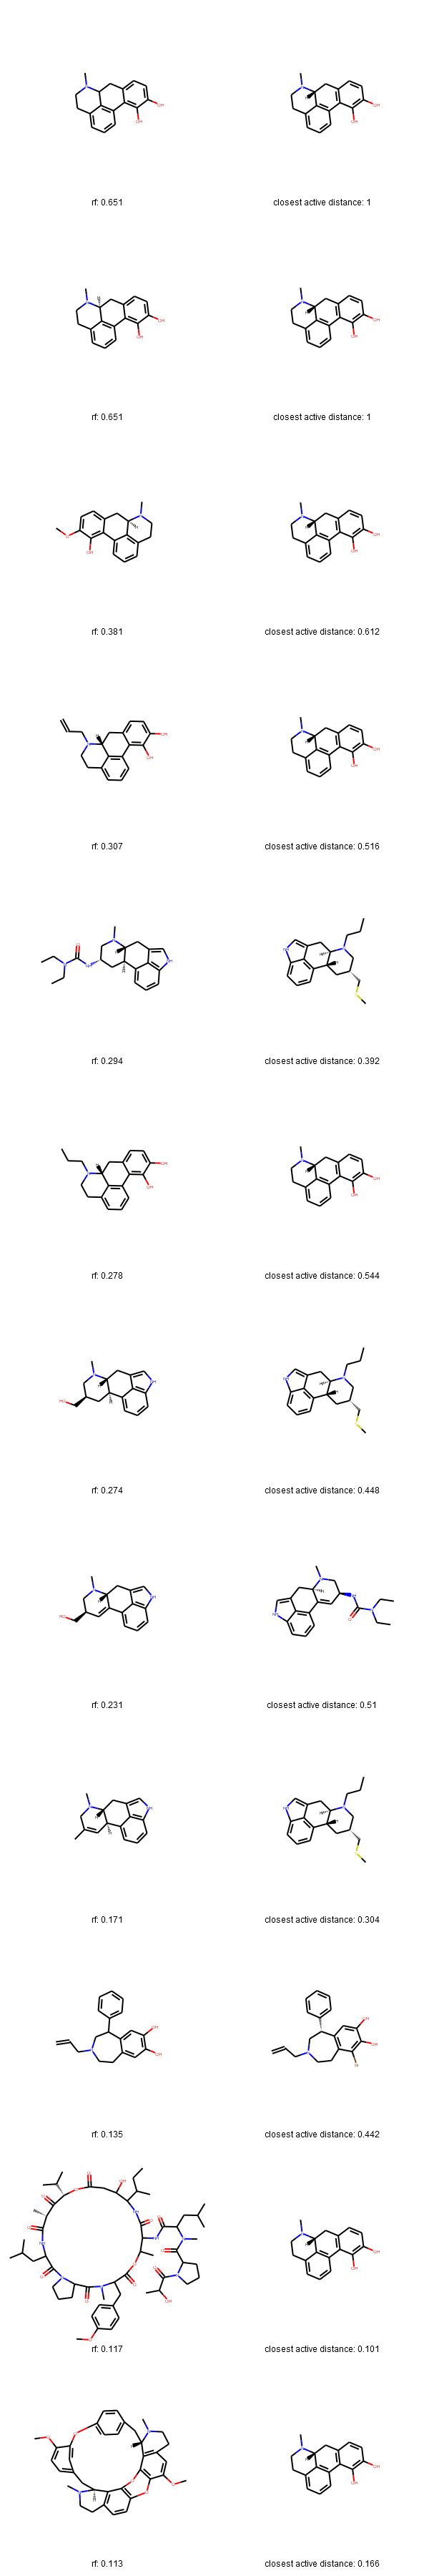

In [20]:
from rdkit.Chem import Draw
topk = 12
draw_mols = [rdkit_mlpcn_mols.iloc[i] for i in np.argsort(rf_mlpcn_preds)[::-1][:topk]]
for m in draw_mols: tmp=AllChem.Compute2DCoords(m)

draw_mols = []
[draw_mols.extend([rdkit_mlpcn_mols.iloc[i], rdkit_train_mols.iloc[closest_active_idx[i]]]) for i in np.argsort(rf_mlpcn_preds)[::-1][:topk]]

legends = []
[legends.extend(['rf: {:.3g}'.format(rf_mlpcn_preds[i]), 
                 'closest active distance: {:.3g}'.format(bl_mlpcn_preds[i])]) for i in np.argsort(rf_mlpcn_preds)[::-1][:topk]]

    
img=Draw.MolsToGridImage(draw_mols,molsPerRow=2,subImgSize=(300,300),legends=legends)
img

---
## Prediction on Aldrich Pool

In [68]:
aldrich_df = pd.read_csv('../../zinc/datasets/filtered_aldrich_prediction_wbaseline_019_0223.csv.gz')
aldrich_df = aldrich_df.dropna()
aldrich_df = aldrich_df.drop_duplicates('rdkit SMILES')
aldrich_df = aldrich_df.reset_index()
aldrich_df = aldrich_df[~aldrich_df['rdkit SMILES'].isin(pd.merge(aldrich_df, raw_df, on='rdkit SMILES')['rdkit SMILES'])]

In [72]:
batch_size = 100000
total_batches = aldrich_df.shape[0] // batch_size + 1
saltRemover = SaltRemover(defnFilename='../datasets/Salts.txt')

rf_ald_preds = np.zeros(shape=(aldrich_df.shape[0]), dtype='float16')
bl_ald_preds = np.zeros(shape=(aldrich_df.shape[0]), dtype='float16')
closest_active_idx = np.zeros(shape=(aldrich_df.shape[0]), dtype='uint8')
for bi in range(total_batches):
    chunk = aldrich_df.iloc[bi*batch_size: (bi+1)*batch_size,:]
    rdkit_ald_mols = chunk['rdkit SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
    rdkit_ald_mols = rdkit_ald_mols.apply((lambda x: saltRemover.StripMol(x)))
    chunk['MorganFP_{}_{}'.format(FP_radius, FP_size)] = rdkit_ald_mols.apply((lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 
                                                                                   radius=FP_radius, 
                                                                                   nBits=FP_size).ToBitString()))
    
    X_chunk = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in chunk['MorganFP_{}_{}'.format(FP_radius, FP_size)]]).astype(float) 

    # RandomForest Model
    rf_ald_preds[bi*batch_size:(bi+1)*batch_size] = rf_model.predict_proba(X_chunk)[:,1]
    # Similarity Baseline model
    bl_preds, cl_idx = bl_model.predict_proba(X_chunk)
    closest_active_idx[bi*batch_size:(bi+1)*batch_size]  = cl_idx[:,0]
    bl_ald_preds[bi*batch_size:(bi+1)*batch_size] = bl_preds[:,0]
    
    print('Done batch: {} out {}.'.format(bi, total_batches))

C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 0 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 1 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 2 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 3 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 4 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 5 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 6 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 7 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 8 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 9 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 10 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 11 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 12 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 13 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 14 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 15 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 16 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 17 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 18 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 19 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 20 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 21 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 22 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 23 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 24 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 25 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 26 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 27 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 28 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 29 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 30 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 31 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 32 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 33 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 34 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 35 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 36 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 37 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 38 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 39 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 40 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 41 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 42 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 43 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 44 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 45 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 46 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 47 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 48 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 49 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 50 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 51 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 52 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 53 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 54 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 55 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 56 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 57 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 58 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 59 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 60 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 61 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 62 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 63 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 64 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 65 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 66 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 67 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 68 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 69 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 70 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 71 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 72 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 73 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 74 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 75 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 76 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 77 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 78 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 79 out 81.


C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


Done batch: 80 out 81.


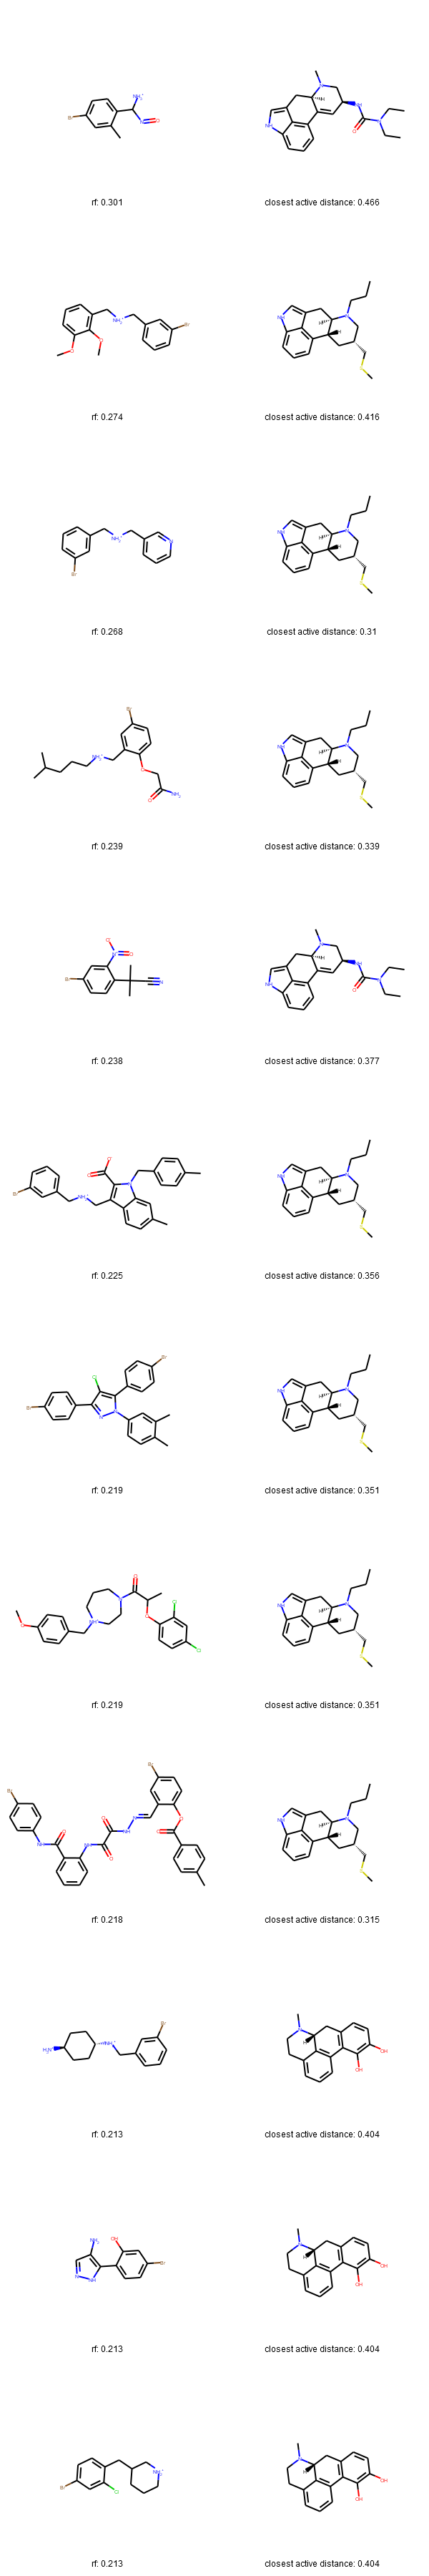

In [80]:
from rdkit.Chem import Draw
topk = 12
rdkit_aldrich_mols = aldrich_df.iloc[np.argsort(rf_mlpcn_preds)[::-1][:topk],:]['rdkit SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
rdkit_aldrich_mols = rdkit_aldrich_mols.apply((lambda x: saltRemover.StripMol(x)))
rdkit_aldrich_mols

for m in rdkit_aldrich_mols: tmp=AllChem.Compute2DCoords(m)

idx = zip(range(len(rdkit_aldrich_mols)), np.argsort(rf_ald_preds)[::-1][:topk])
draw_mols = []
[draw_mols.extend([rdkit_aldrich_mols.iloc[i], rdkit_train_mols.iloc[closest_active_idx[j]]]) for i,j in idx]

idx = zip(range(len(rdkit_aldrich_mols)), np.argsort(rf_ald_preds)[::-1][:topk])
legends = []
[legends.extend(['rf: {:.3g}'.format(rf_ald_preds[j]), 
                 'closest active distance: {:.3g}'.format(bl_ald_preds[j])]) for i,j in idx]

    
img=Draw.MolsToGridImage(draw_mols,molsPerRow=2,subImgSize=(300,300),legends=legends)
img

---
## Generate final prediction dataframe

In [129]:
mlpcn_lc_df['RF Hit Prob'] = rf_mlpcn_preds
mlpcn_lc_df['BL Hit Prob'] = bl_mlpcn_preds
mlpcn_lc_df['original SMILES'] = mlpcn_lc_df['CDD SMILES']

aldrich_df['RF Hit Prob'] = rf_ald_preds
aldrich_df['BL Hit Prob'] = bl_ald_preds

merged_df = pd.concat([mlpcn_lc_df[['original SMILES', 'rdkit SMILES', 'RF Hit Prob', 'BL Hit Prob']],
                       aldrich_df[['original SMILES', 'rdkit SMILES', 'RF Hit Prob', 'BL Hit Prob']]])
merged_df = merged_df.sort_values(by='RF Hit Prob', ascending=False)

merged_df.to_csv('./model_predictions.csv.gz', index=False, compression='gzip')

C:\Users\Moeman\Anaconda3\envs\my-rdkit-env\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]


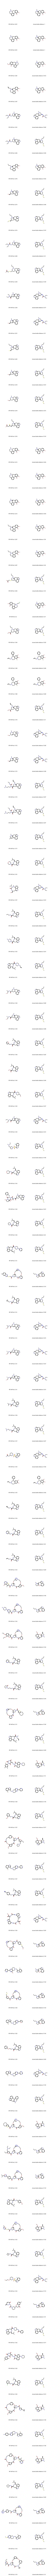

In [131]:
from rdkit.Chem import Draw
topk = 100
rf_preds = merged_df['RF Hit Prob'].values
bl_preds = merged_df['BL Hit Prob'].values
sorted_idx = np.argsort(rf_preds)[::-1][:topk]

chunk = merged_df.iloc[sorted_idx,:]
mols = chunk['rdkit SMILES'].astype(str).apply((lambda x: Chem.MolFromSmiles(x)))
mols = mols.apply((lambda x: saltRemover.StripMol(x)))
fps = mols.apply((lambda x: AllChem.GetMorganFingerprintAsBitVect(x, radius=FP_radius, 
                                                                  nBits=FP_size).ToBitString()))

X = np.vstack([np.fromstring(x, 'u1') - ord('0') for x in fps]).astype(float) 

# Similarity Baseline model
_, closest_active_idx = bl_model.predict_proba(X)
closest_active_idx = closest_active_idx[:,0]

for m in mols: tmp=AllChem.Compute2DCoords(m)

draw_mols = []
[draw_mols.extend([mols.iloc[i], rdkit_train_mols.iloc[closest_active_idx[i]]]) for i in range(len(mols))]

idx = zip(range(len(mols)), sorted_idx)
legends = []
[legends.extend(['RF Hit Prob: {:.3g}'.format(rf_preds[j]), 
                 'closest active distance: {:.3g}'.format(bl_preds[j])]) for i,j in idx]

    
img=Draw.MolsToGridImage(draw_mols,molsPerRow=2,subImgSize=(300,300),legends=legends)
img